In [1]:
import jax

jax.config.update("jax_enable_x64", True)

import astropy.units as u
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astroquery.jplhorizons import Horizons

from jorbit import Observations, Particle

In [2]:
nights = [Time("2025-01-01 07:00"), Time("2025-01-02 07:00"), Time("2025-01-05 07:00")]

times = []
for n in nights:
    times.extend([n + i * 1 * u.hour for i in range(3)])
times = Time(times)


obj = Horizons(id="274301", location="695@399", epochs=times.utc.jd)
pts = obj.ephemerides(extra_precision=True, quantities="1")

coords = SkyCoord(pts["RA"], pts["DEC"], unit=(u.deg, u.deg))
times = Time(pts["datetime_jd"], format="jd", scale="utc")

[Text(0.5, 0, 'RA'), Text(0, 0.5, 'DEC')]

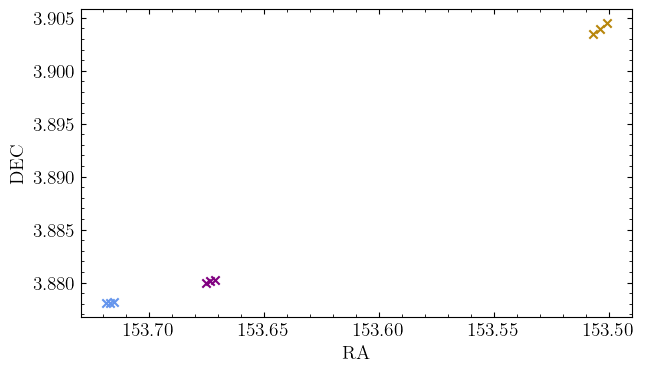

In [3]:
fig, ax = plt.subplots()
ax.scatter(coords.ra[:3], coords.dec[:3], c="cornflowerblue", marker="x")
ax.scatter(coords.ra[3:6], coords.dec[3:6], c="purple", marker="x")
ax.scatter(coords.ra[6:], coords.dec[6:], c="darkgoldenrod", marker="x")
ax.set_xlim(ax.get_xlim()[::-1])
ax.set(xlabel="RA", ylabel="DEC")

In [4]:
obs = Observations(
    observed_coordinates=coords,
    times=times,
    observatories="kitt peak",
    astrometric_uncertainties=1 * u.arcsec,
)
obs

Observations with 9 set(s) of observations

In [5]:
obj = Horizons(id="274301", location="500@0", epochs=times.tdb.jd[0])
vecs = obj.vectors(refplane="earth")
true_x0 = jnp.array([vecs["x"], vecs["y"], vecs["z"]]).T[0]
true_v0 = jnp.array([vecs["vx"], vecs["vy"], vecs["vz"]]).T[0]
true_x0, true_v0

(Array([-2.00572346,  1.77860123,  0.51974075], dtype=float64),
 Array([-0.00665991, -0.00662871, -0.00203885], dtype=float64))

In [6]:
p0 = Particle(
    x=true_x0, v=true_v0, time=times[0], name="274301 Wikipedia", observations=obs
)
p0.residuals(p0.cartesian_state)

Array([[-2.87339636e-07, -5.02575849e-07],
       [ 8.18942481e-07, -1.30201933e-06],
       [-5.50803589e-07, -1.08846230e-06],
       [-1.06660985e-06, -1.20895735e-06],
       [-1.20654022e-06,  9.83773836e-07],
       [ 4.05506364e-07,  1.00282958e-06],
       [ 1.25702853e-06,  9.60043735e-07],
       [-7.21025140e-08, -3.30322537e-07],
       [-4.76495202e-07, -1.59054096e-07]], dtype=float64)

In [7]:
p0.keplerian_state

KeplerianState(semi=Array([2.37859645], dtype=float64), ecc=Array([0.14924503], dtype=float64), inc=Array([6.73363597], dtype=float64), Omega=Array([183.37294141], dtype=float64), omega=Array([140.26387023], dtype=float64), nu=Array([173.6546239], dtype=float64), acceleration_func_kwargs={'c2': 29979.063823897617}, time=np.float64(2460676.792467407))

In [8]:
p1 = Particle(
    x=true_x0 + 1e-2, v=true_v0 - 1e-3, time=times[0], name="test particle", observations=obs
)
p1.residuals(p1.cartesian_state)

Array([[-1364.96106289,  1048.0356631 ],
       [-1359.59778599,  1043.90358193],
       [-1354.23108953,  1039.76852961],
       [-1235.37787807,   948.24573116],
       [-1229.95182932,   944.06693221],
       [-1224.5223831 ,   939.88524014],
       [ -837.60552771,   642.21750987],
       [ -831.98868011,   637.89918206],
       [ -826.36857411,   633.57825304]], dtype=float64)

In [9]:
p_fit = p1.max_likelihood()
fit_resids = p_fit.residuals(p_fit.cartesian_state)
fit_resids

Array([[-1.72061494e-04, -7.18734086e-04],
       [-9.19918360e-05, -6.38573169e-04],
       [ 1.11325289e-05, -5.57889674e-04],
       [ 9.24509983e-06,  8.12899833e-04],
       [ 1.06292623e-04,  8.47946406e-04],
       [ 2.28225020e-04,  8.80628593e-04],
       [-5.69403408e-05, -1.49331246e-04],
       [-3.64845010e-05, -2.09730116e-04],
       [ 1.16264360e-06, -2.67999121e-04]], dtype=float64)

In [10]:
p_fit.keplerian_state

KeplerianState(semi=Array([2.37724575], dtype=float64), ecc=Array([0.14982428], dtype=float64), inc=Array([6.73732964], dtype=float64), Omega=Array([183.34436143], dtype=float64), omega=Array([139.77674993], dtype=float64), nu=Array([174.17180701], dtype=float64), acceleration_func_kwargs={'c2': 29979.063823897617}, time=np.float64(2460676.792467407))

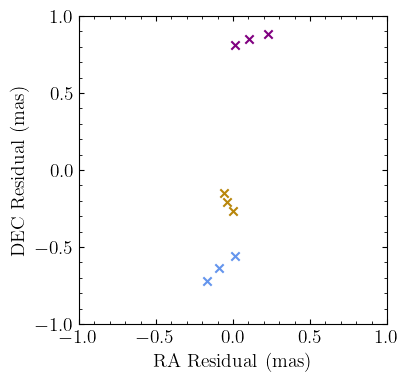

In [11]:
fig, ax = plt.subplots()
ax.scatter(fit_resids[:3, 0] * 1_000, fit_resids[:3, 1] * 1_000, c="cornflowerblue", marker="x")
ax.scatter(fit_resids[3:6, 0] * 1_000, fit_resids[3:6, 1] * 1_000, c="purple", marker="x")
ax.scatter(fit_resids[6:, 0] * 1_000, fit_resids[6:, 1] * 1_000, c="darkgoldenrod", marker="x")
ax.set(
    aspect="equal",
    xlim=(-1, 1),
    ylim=(-1, 1),
    xlabel="RA Residual (mas)",
    ylabel="DEC Residual (mas)",
);

In [12]:
ephem = p_fit.ephemeris(
    Time(np.linspace(times[0].utc.jd, times[-1].utc.jd, 500), format="jd", scale="utc"),
    observer="kitt peak",
)

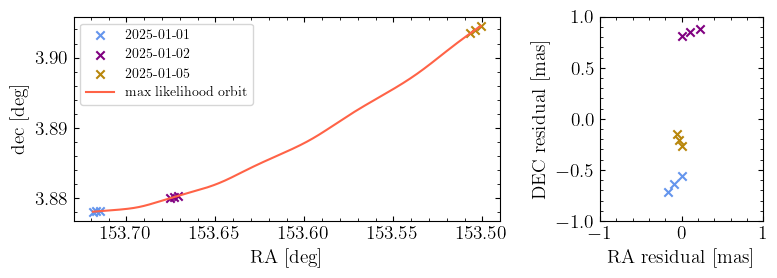

In [13]:
fig = plt.figure(figsize=(8, 3))
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2])

ax1.scatter(coords.ra[:3], coords.dec[:3], c="cornflowerblue", marker="x", label="2025-01-01")
ax1.scatter(coords.ra[3:6], coords.dec[3:6], c="purple", marker="x", label="2025-01-02")
ax1.scatter(coords.ra[6:], coords.dec[6:], c="darkgoldenrod", marker="x", label="2025-01-05")
ax1.plot(ephem.ra, ephem.dec, c="tomato", label="max likelihood orbit")
ax1.set(xlabel="RA [deg]", ylabel="dec [deg]")
ax1.set_xlim(ax1.get_xlim()[::-1])
ax1.legend(fontsize="10")

ax2.scatter(fit_resids[:3, 0] * 1_000, fit_resids[:3, 1] * 1_000, c="cornflowerblue", marker="x")
ax2.scatter(fit_resids[3:6, 0] * 1_000, fit_resids[3:6, 1] * 1_000, c="purple", marker="x")
ax2.scatter(fit_resids[6:, 0] * 1_000, fit_resids[6:, 1] * 1_000, c="darkgoldenrod", marker="x")
ax2.set(
    xlim=(-1, 1),
    ylim=(-1, 1),
    xlabel="RA residual [mas]",
    ylabel="DEC residual [mas]",
)

plt.tight_layout()
plt.savefig("figures/max_likelihood_orbit.pdf")

In [14]:
from jorbit.astrometry.orbit_fit_seeds import gauss_method_orbit

p_fit.residuals(gauss_method_orbit(obs[::3]))

Array([[-10.61788991,   2.67988077],
       [-10.53195155,   2.63791146],
       [-10.44595078,   2.59592053],
       [ -8.54784752,   1.66684393],
       [ -8.46118057,   1.62437976],
       [ -8.37445611,   1.58189282],
       [ -2.24569236,  -1.43722502],
       [ -2.1573558 ,  -1.48094835],
       [ -2.06899393,  -1.5246833 ]], dtype=float64)

In [15]:
for i in p0.keplerian_state.items():
    if isinstance(i[1], dict):
        continue
    print(f"{i[0]}: {1-p0.keplerian_state[i[0]] / p_fit.keplerian_state[i[0]]}")

semi: [-0.00056818]
ecc: [0.00386621]
inc: [0.00054824]
Omega: [-0.00015588]
omega: [-0.00348499]
nu: [0.00296938]
time: 0.0


In [16]:
p_fit.loglike(p_fit.keplerian_state)

Array(-16.54089542, dtype=float64)

In [17]:
p_fit.keplerian_state.semi - p_fit.keplerian_state.semi*0.03

Array([2.30592838], dtype=float64)

In [ ]:
from jorbit.utils.states import KeplerianState

@jax.jit
def tmp(a):
    k = KeplerianState(
        semi=a,
        ecc=p_fit.keplerian_state["ecc"],
        nu=p_fit.keplerian_state["nu"],
        inc=p_fit.keplerian_state["inc"],
        Omega=p_fit.keplerian_state["Omega"],
        omega=p_fit.keplerian_state["omega"],
        time=p_fit.keplerian_state.time,
        acceleration_func_kwargs=p_fit.keplerian_state.acceleration_func_kwargs,
    )
    return p_fit.loglike(k)

width = p_fit.keplerian_state.semi*0.03
semis = jnp.linspace(p_fit.keplerian_state.semi - width, 
                     p_fit.keplerian_state.semi + width, 100)

In [ ]:
print(tmp(semis[0]))
print(jax.grad(tmp)(semis[0]))
print(jax.jacfwd(lambda x: jax.grad(tmp)(x)[0])(semis[0]))

-28778452.03091496
[8.39991961e+08]
[-1.32202975e+10]


In [24]:
lls = [tmp(s) for s in semis]
grad_lls = [jax.grad(tmp)(s) for s in semis]
grad_grad_lls = [jax.jacfwd(lambda x: jax.grad(tmp)(x)[0])(s) for s in semis]

In [25]:
lls = jnp.array(lls)
grad_lls = jnp.array(grad_lls)
grad_grad_lls = jnp.array(grad_grad_lls).flatten()

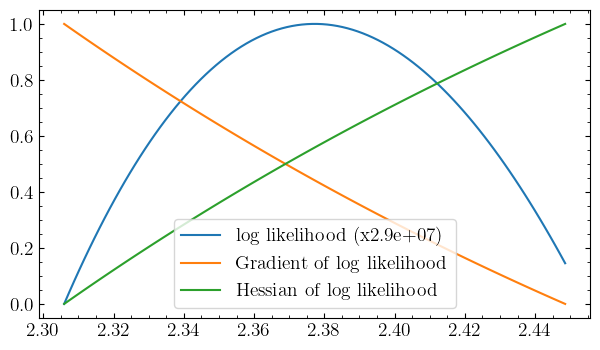

In [32]:
n = jnp.ptp(lls)
plt.plot(semis, (lls - jnp.min(lls)) / n, label=f"log likelihood (x{n:.1e})" )
n = jnp.ptp(grad_lls)
plt.plot(semis, (grad_lls - jnp.min(grad_lls)) / n, label="Gradient of log likelihood")
n = jnp.ptp(grad_grad_lls)
plt.plot(semis, (grad_grad_lls - jnp.min(grad_grad_lls)) / n, label="Hessian of log likelihood")
plt.legend()

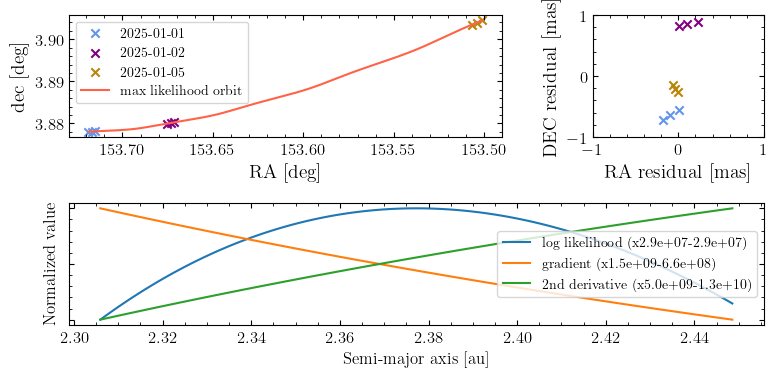

In [41]:
fig = plt.figure(figsize=(8, 4))  # Increased height to accommodate new subplot
gs = fig.add_gridspec(2, 3)  # 2 rows, 3 columns
ax1 = fig.add_subplot(gs[0, 0:2])  # Top row, first two columns
ax2 = fig.add_subplot(gs[0, 2])    # Top row, third column
ax3 = fig.add_subplot(gs[1, :])    # Bottom row, all columns (spans full width)

ax1.scatter(coords.ra[:3], coords.dec[:3], c="cornflowerblue", marker="x", label="2025-01-01")
ax1.scatter(coords.ra[3:6], coords.dec[3:6], c="purple", marker="x", label="2025-01-02")
ax1.scatter(coords.ra[6:], coords.dec[6:], c="darkgoldenrod", marker="x", label="2025-01-05")
ax1.plot(ephem.ra, ephem.dec, c="tomato", label="max likelihood orbit")
ax1.set(xlabel="RA [deg]", ylabel="dec [deg]")
ax1.set_xlim(ax1.get_xlim()[::-1])
ax1.legend(fontsize="10")

ax2.scatter(fit_resids[:3, 0] * 1_000, fit_resids[:3, 1] * 1_000, c="cornflowerblue", marker="x")
ax2.scatter(fit_resids[3:6, 0] * 1_000, fit_resids[3:6, 1] * 1_000, c="purple", marker="x")
ax2.scatter(fit_resids[6:, 0] * 1_000, fit_resids[6:, 1] * 1_000, c="darkgoldenrod", marker="x")
ax2.set(
    xlim=(-1, 1),
    ylim=(-1, 1),
    xlabel="RA residual [mas]",
    ylabel="DEC residual [mas]",
)

n = jnp.ptp(lls)
ax3.plot(semis, (lls - jnp.min(lls)) / n, label=f"log likelihood (x{n:.1e}{jnp.min(lls):.1e})")
n = jnp.ptp(grad_lls)
ax3.plot(semis, (grad_lls - jnp.min(grad_lls)) / n, label=f"gradient (x{n:.1e}{jnp.min(grad_lls):.1e})")
n = jnp.ptp(grad_grad_lls)
ax3.plot(semis, (grad_grad_lls - jnp.min(grad_grad_lls)) / n, label=f"2nd derivative (x{n:.1e}{jnp.min(grad_grad_lls):.1e})")
ax3.legend(fontsize="10")

ax3.set_xlabel("Semi-major axis [au]", fontsize=12)
ax3.set_ylabel("Normalized value", fontsize=12)
ax3.set_yticklabels([])

ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
ax3.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/max_likelihood_orbit.pdf", bbox_inches="tight")

In [2]:
"""Tests that the acceleration functions agree with external codes."""

import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np
import rebound
import reboundx

from jorbit.accelerations.gr import ppn_gravity
from jorbit.accelerations.newtonian import newtonian_gravity
from jorbit.utils.states import SystemState


def _gr_agreement_w_reboundx(n_tracer: int, n_massive: int, seed: int) -> None:
    """Test that the jorbit GR acceleration is consistent with reboundx."""
    np.random.seed(seed)
    massive_x = []
    massive_v = []
    ms = []
    sim = rebound.Simulation()
    for _i in range(n_massive):
        xs = np.random.normal(0, 1, 3) * 1000
        vs = np.random.normal(0, 1, 3)
        massive_x.append(xs)
        massive_v.append(vs)
        m = np.random.uniform(0, 1)
        ms.append(m)
        sim.add(m=m, x=xs[0], y=xs[1], z=xs[2], vx=vs[0], vy=vs[1], vz=vs[2])
    tracer_x = []
    tracer_v = []
    for _i in range(n_tracer):
        xs = np.random.normal(0, 1, 3) * 1000
        vs = np.random.normal(0, 1, 3)
        tracer_x.append(xs)
        tracer_v.append(vs)
        sim.add(m=0.0, x=xs[0], y=xs[1], z=xs[2], vx=vs[0], vy=vs[1], vz=vs[2])
    rebx = reboundx.Extras(sim)
    gr = rebx.load_force("gr_full")
    gr.params["c"] = 10
    gr.params["max_iterations"] = 100
    rebx.add_force(gr)
    sim.integrate(1e-300)
    reb_res = jnp.array([[p.ax, p.ay, p.az] for p in sim.particles])

    tracer_x = jnp.array(tracer_x)
    tracer_v = jnp.array(tracer_v)
    massive_x = jnp.array(massive_x)
    massive_v = jnp.array(massive_v)
    ms = jnp.array(ms)
    s = SystemState(
        tracer_positions=tracer_x,
        tracer_velocities=tracer_v,
        massive_positions=massive_x,
        massive_velocities=massive_v,
        log_gms=jnp.log(ms),
        time=0.0,
        acceleration_func_kwargs={"c2": 100.0},
    )
    jorb_res = ppn_gravity(s)

    # print(jnp.max(jnp.abs(jorb_res - reb_res)))
    assert jnp.allclose(jorb_res, reb_res, atol=1e-14, rtol=1e-14)


_gr_agreement_w_reboundx(n_tracer=1, n_massive=1, seed=0)

In [2]:
reboundx.__version__

'4.4.0'

In [3]:
rebound.__version__

'4.4.5'